# Summary

This section should be a short summary of what you did and what you found.  It should be between one to three paragraphs. Put anything you want to be sure the reviewer reads into an executive summary. Write the summary, as well as the rest of the code, as if it was a project you were presenting to people unfamiliar with the work you are doing.  Assume they are knowledgeable about the topic but not the specifics of your task or the underlying data.  Use hyperlinks to link to specific figures and sections you are referencing in the notebook.  Comment about positive findings and pertinent negatives, e.g. always check for missing values, but only reference them in the summary if there is something unique about them.

This report is meant to answer the following question.  Can I predict how long a ride will from the time and place of departure, as well as some minimal information about the rider?

I'm examining three months of citibike rider data, from July through September of 2019, totaling about 7 million rides.  The only significant peculiarity in the data, is a spike in the rider birth year for the year 1969.  There are about 7 times more riders "born" in 1969 than the surrounding year.  I would assume that 1969 is the default birth year when users create accounts.

As seen in [this figure](#trip_dur_vs_cum_prcnt), 50% of all rides are 10 minutes or less and over 90% of all rides are shorter than 30 minutes.  While there are [less riders on Sundays](#dow_avg_count) as compared to the rest of the week, this does not explain daily ridership, as seen [here](#date_dow_count).  There is some other external factor, most probably weather, which has a stronger influence on the probability of a ride.   

When trying to predict the length of a ride, none of the non-engineered variables are significantly correlated with trip duration, as seen [here](#corr_plot).


## Other

List of useful tools
- Black for jupyter notebooks
    - https://github.com/drillan/jupyter-black
- spellcheck for jupyter notebooks (part of [nbextensions](https://jupyter-contrib-nbextensions.readthedocs.io/en/latest/index.html))
    - https://jupyter-contrib-nbextensions.readthedocs.io/en/latest/nbextensions/spellchecker/README.html


List of good newsletters/Data science articles:

- NYC data Jobs and Events by Josh Laurito
    - https://tinyletter.com/nycdatajobs
- Normcore Tech by Vicki Boykis
    - https://vicki.substack.com/
- Data Science Roundup by Tristan Handy
    - http://roundup.fishtownanalytics.com/
- The Algorithm from MIT Technology Review
    - https://forms.technologyreview.com/newsletters/
- PyCoder's Weekly     
    - https://pycoders.com/
- Natural Language Processing News by Sebastian Ruder
    - http://newsletter.ruder.io/

# Readme

This section should contain any technical information required to run your code.  At least list the version of python your code was running on, as well as the package versions.  If your code uses a lot of memory, takes a long time to run or some other technical nuance that you want to inform the reader about, place it here.

The code below was run on the following:
- python 3.7.4
- pandas 0.25.1
- pandas-profiling 2.3.0
- altair 3.3.0.dev0
- numpy 1.17.2
- jupyter 1.0.0
- geopy 1.20.0

# Imports and Functions

In [213]:
import pandas as pd
import altair as alt
import numpy as np
import pandas_profiling
from IPython.display import display
import os
from geopy import distance
from typing import Tuple

In [2]:
# Run this cell only if you are running this in a jupyter notebook
alt.renderers.enable('notebook')

RendererRegistry.enable('notebook')

In [171]:
def alt_hist(df: pd.DataFrame, col_of_int: str) -> pd.DataFrame:
    """
    Create a dataframe of the counts of each value
    """
    df_tmp = df[[col_of_int]].copy()
    df_tmp["col_count"] = 1
    df_tmp = df_tmp.groupby(col_of_int, as_index=False, sort=False).count()
    df_tmp = df_tmp.sort_values(col_of_int).reset_index(drop=True)
    return df_tmp

In [61]:
def standard_props(chart: alt.Chart) -> alt.Chart:
    """ 
    Default values for Altair charts
    """
    chart = (
        chart.properties(height=300, width=700)
        .configure_axis(labelFontSize=15, titleFontSize=20)
        .configure_legend(
            titleFontSize=18, labelFontSize=12, titleLimit=250, labelLimit=200
        )
        .configure_header(titleFontSize=20, labelFontSize=15)
    )
    return chart

In [214]:
def train_test_split(
    df: pd.DataFrame, train_smp: int, test_smp: int, rand_state: int = 44
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Split the data into a training and testing dataframe.
    """
    train_smp = min(train_smp, int(df.shape[0] * 0.8))
    test_smp = min(test_smp, int(df.shape[0] * 0.2))
    total_smp = train_smp + test_smp
    df_smp = df.sample(total_smp, random_state=rand_state)
    df_smp_train = df_smp.iloc[:train_smp, :]
    df_smp_test = df_smp.iloc[train_smp:, :]
    return (df_smp_train, df_smp_test)

# Download and Concatenate the Data

In [3]:
!mkdir data
!mkdir data/raw
!wget -P data/raw https://s3.amazonaws.com/tripdata/201909-citibike-tripdata.csv.zip
!wget -P data/raw https://s3.amazonaws.com/tripdata/201908-citibike-tripdata.csv.zip
!wget -P data/raw https://s3.amazonaws.com/tripdata/201907-citibike-tripdata.csv.zip

--2019-10-25 12:03:24--  https://s3.amazonaws.com/tripdata/201909-citibike-tripdata.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.134.29
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.134.29|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 104185546 (99M) [application/zip]
Saving to: ‘data/raw/201909-citibike-tripdata.csv.zip’

201909-citibike-tri 100%[===================>]  99.36M  90.0MB/s    in 1.1s    

2019-10-25 12:03:26 (90.0 MB/s) - ‘data/raw/201909-citibike-tripdata.csv.zip’ saved [104185546/104185546]

--2019-10-25 12:03:26--  https://s3.amazonaws.com/tripdata/201908-citibike-tripdata.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.36.102
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.36.102|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 100021943 (95M) [application/zip]
Saving to: ‘data/raw/201908-citibike-tripdata.csv.zip’

201908-citibike-tri 100%[===================>]

In [5]:
!unzip -q data/raw/201909-citibike-tripdata.csv.zip -d data/raw/
!unzip -q data/raw/201908-citibike-tripdata.csv.zip -d data/raw/
!unzip -q data/raw/201907-citibike-tripdata.csv.zip -d data/raw/

In [7]:
cb_csv = [x for x in os.listdir("data/raw") if x.endswith(".csv")]
df_cb_list = []
for csv in cb_csv:
    df_cb_list.append(pd.read_csv(os.path.join("data/raw",csv)))
df_cb = pd.concat(df_cb_list, ignore_index=True, sort=False)
del df_cb_list
df_cb = df_cb.rename(columns={x:x.replace(" ", "_") for x in df_cb.columns})

In [10]:
df_cb.to_feather("data/citibike_data_201907-201909.feather")

# Load the Data

In [9]:
df_cb = pd.read_feather("data/citibike_data_201907-201909.feather")
df_cb.shape

(6970188, 15)

In [11]:
df_cb.starttime = pd.to_datetime(df_cb.starttime, format="%Y-%m-%d %H:%M:%S.%f")
df_cb.stoptime = pd.to_datetime(df_cb.stoptime, format="%Y-%m-%d %H:%M:%S.%f")

# Profile the Data

In [13]:
# profile = df_cb.profile_report(title="Pandas Profiling Report")
# profile.to_file(output_file="data/citibike_data_report.html")

# EDA

**EDA General Guidelines**

- You need to look at the data.  Just because pandas says there are no missing values, doesn't mean there aren't thousands of fields that say "none" or "NULL".
- Look for outliers and values that make no sense and remove, correct, or impute them as necessary. But make sure to **explain why you are altering the data**
- Initially, only do the basic EDA/sanity checks.  If you have more time, do more, but do not spend your entire alloted time doing EDA

## Trip Duration, Start Time, End Time

### Sanity Checks

#### Check for missing values

In [80]:
df_cb[["starttime", "stoptime", "tripduration"]].isna().sum()

starttime       0
stoptime        0
tripduration    0
dtype: int64

#### No one arrives before they leave

In [77]:
(df_cb.starttime > df_cb.stoptime).sum()

0

#### The trip duration matches the difference between the `starttime` and the `stoptime`

In [14]:
df_cb["calculatedduration"] = (df_cb.stoptime - df_cb.starttime).dt.total_seconds().astype(int)
df_cb.loc[df_cb.calculatedduration != df_cb.tripduration, ["calculatedduration", "tripduration"]]
df_cb["duration_diff"] = df_cb.calculatedduration -  df_cb.tripduration
df_cb.duration_diff.value_counts()

0    6970188
Name: duration_diff, dtype: int64

### Trip Duration

In [15]:
df_cb["tripduration_min"] = (df_cb.tripduration/60).astype(int)

In [176]:
col_of_int = "tripduration_min"
col_title = "Trip Duration (Minutes)"
df_trip_dur = alt_hist(df_cb, col_of_int=col_of_int)
df_trip_dur["cum_prcnt"] = df_trip_dur.col_count.cumsum()/df_trip_dur.col_count.sum()

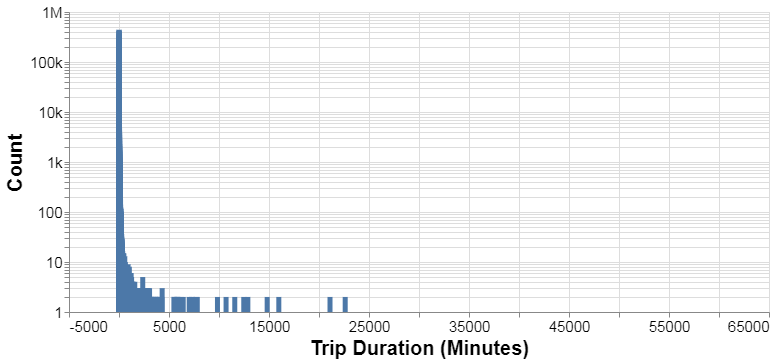

In [174]:
col_of_int = "tripduration_min"
col_title = "Trip Duration (Minutes)"

p = alt.Chart(df_trip_dur).mark_bar().encode(
    x = alt.X(col_of_int, title=col_title, axis=alt.Axis(format="c")),
    y = alt.Y("col_count", title="Count", axis=alt.Axis(format="s"), scale=alt.Scale(type="log", base=10)),
    tooltip=[alt.Tooltip("col_count", title="Count", format="~s"),
            alt.Tooltip(col_of_int, title=col_title)]
)
standard_props(p).interactive()

<a id='trip_dur_vs_cum_prcnt'></a>

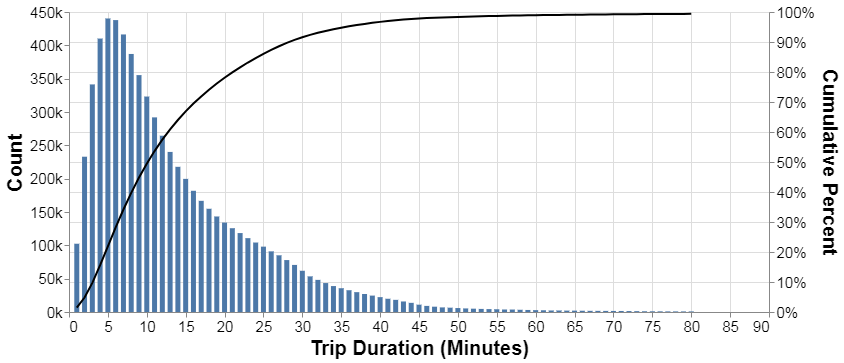

In [185]:
col_of_int = "tripduration_min"
col_title = "Trip Duration (Minutes)"

p1 = alt.Chart(df_trip_dur.loc[df_trip_dur.tripduration_min <= 80]).mark_bar().encode(
    x=alt.X(
        col_of_int, title=col_title, axis=alt.Axis(format="c")
    ),
    y=alt.Y("col_count", title="Count", axis=alt.Axis(format="s")),
    tooltip=[
        alt.Tooltip("col_count", title="Count", format="~s"),
        alt.Tooltip(col_of_int, title=col_title),
    ],
)

p2 = alt.Chart(df_trip_dur.loc[df_trip_dur.tripduration_min <= 80]).mark_line(color="black").encode(
    x=alt.X(
        col_of_int, title=col_title, axis=alt.Axis(format="c")
    ),
    y=alt.Y("cum_prcnt", title="Cumulative Percent", axis=alt.Axis(format="%", grid=True)),
)


standard_props(p1+p2).resolve_scale(y='independent')

### Start Time

In [23]:
df_cb["start_month"] = df_cb.starttime.dt.month
df_cb["start_day"] = df_cb.starttime.dt.day
df_cb["start_date"] = pd.to_datetime(df_cb.starttime.dt.date, format="%Y-%m-%d")
df_cb["start_dow"] = df_cb.starttime.dt.day_name()
df_cb["start_hour"] = df_cb.starttime.dt.hour

<a id='date_dow_count'></a>

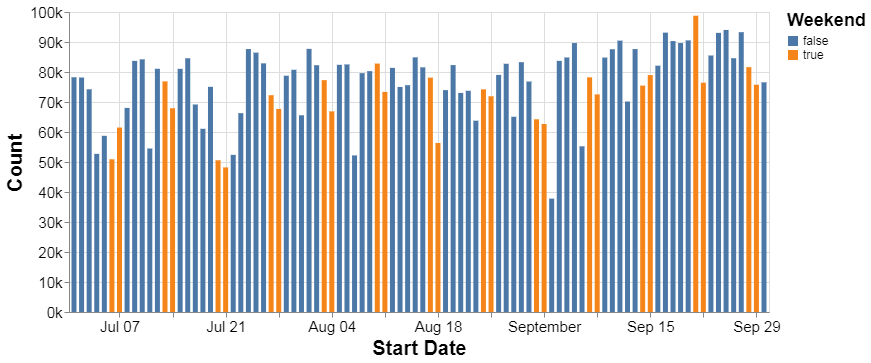

In [207]:
col_of_int = "start_date:T"
col_title = "Start Date"

df_start_date = alt_hist(df_cb, col_of_int="start_date")
df_start_date = df_start_date.merge(
    df_cb[["start_date", "start_dow"]].drop_duplicates(), on="start_date", how="left"
)
df_start_date["weekend"] = False
df_start_date.loc[df_start_date.start_dow.isin(["Saturday", "Sunday"]), "weekend"] = True


p = (
    alt.Chart(df_start_date)
    .mark_bar()
    .encode(
        x=alt.X(col_of_int, title=col_title),
        y=alt.Y("col_count", title="Count", axis=alt.Axis(format="s")),
        color=alt.Color("weekend", title="Weekend"),
        tooltip=[
            alt.Tooltip("col_count", title="Count", format="~s"),
            alt.Tooltip(col_of_int, title=col_title),
            alt.Tooltip("start_dow", title="Day of Week"),
        ],
    )
)
standard_props(p).interactive()

<a id='dow_avg_count'></a>

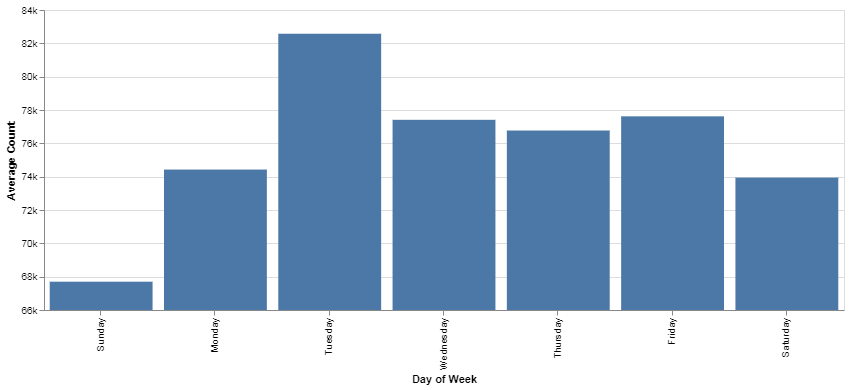

In [208]:
col_of_int = "start_dow"
col_title = "Day of Week"
df_start_dow = df_start_date[["col_count", "start_dow"]].groupby("start_dow", as_index=False, sort=False).mean()

alt.Chart(df_start_dow).mark_bar().encode(
    x=alt.X(
        col_of_int,
        title=col_title,
        sort=[
            "Sunday",
            "Monday",
            "Tuesday",
            "Wednesday",
            "Thursday",
            "Friday",
            "Saturday",
        ],
    ),
    y=alt.Y(
        "col_count",
        title="Average Count",
        axis=alt.Axis(format="s"),
        scale=alt.Scale(zero=False),
    ),
    tooltip=[
        alt.Tooltip("col_count", title="Average Count", format="~s"),
        alt.Tooltip(col_of_int, title=col_title),
    ],
).properties(height=300, width=800).interactive()

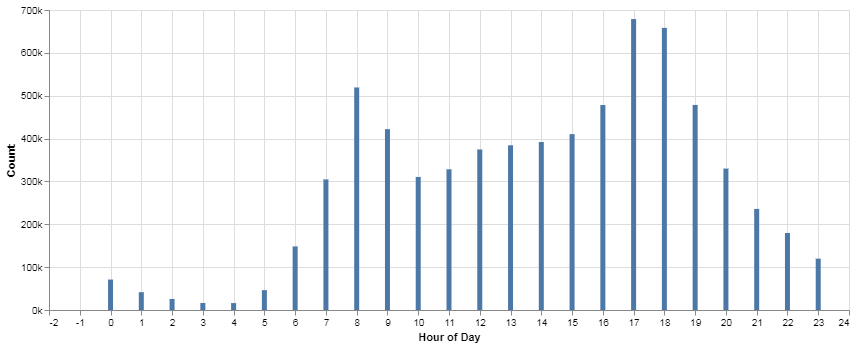

In [73]:
col_of_int = "start_hour"
col_title = "Hour of Day"
df_start_hour = alt_hist(df_cb, col_of_int=col_of_int)

alt.Chart(df_start_hour).mark_bar().encode(
    x=alt.X(
        col_of_int,
        title=col_title,
    ),
    y=alt.Y("col_count", title="Count", axis=alt.Axis(format="s"), scale=alt.Scale(zero=False)),
    tooltip=[
        alt.Tooltip("col_count", title="Count", format="~s"),
        alt.Tooltip(col_of_int, title=col_title),
    ],
).properties(height=300, width=800)

## Start Stations and End Stations

### Sanity Checks

#### Missing Values

In [86]:
df_cb.columns

Index(['tripduration', 'starttime', 'stoptime', 'start_station_id',
       'start_station_name', 'start_station_latitude',
       'start_station_longitude', 'end_station_id', 'end_station_name',
       'end_station_latitude', 'end_station_longitude', 'bikeid', 'usertype',
       'birth_year', 'gender', 'start_month', 'start_day', 'tripduration_min',
       'start_date', 'start_hour', 'start_dow', 'calculatedduration',
       'duration_diff'],
      dtype='object')

In [87]:
df_cb[
    [
        "start_station_id",
        "start_station_name",
        "start_station_latitude",
        "start_station_longitude",
        "end_station_id",
        "end_station_name",
        "end_station_latitude",
        "end_station_longitude",
    ]
].isna().sum()

start_station_id           143
start_station_name         143
start_station_latitude       0
start_station_longitude      0
end_station_id             143
end_station_name           143
end_station_latitude         0
end_station_longitude        0
dtype: int64

#### Check for any empty strings

In [104]:
df_cb.loc[(df_cb.start_station_name.notna()) & (df_cb.start_station_name.str.match("^\s*$"))]

Empty DataFrame
Columns: [tripduration, starttime, stoptime, start_station_id, start_station_name, start_station_latitude, start_station_longitude, end_station_id, end_station_name, end_station_latitude, end_station_longitude, bikeid, usertype, birth_year, gender, start_month, start_day, tripduration_min, start_date, start_hour, start_dow, calculatedduration, duration_diff]
Index: []

[0 rows x 23 columns]

In [105]:
df_cb.loc[(df_cb.end_station_name.notna()) & (df_cb.end_station_name.str.match("^\s*$"))]

Empty DataFrame
Columns: [tripduration, starttime, stoptime, start_station_id, start_station_name, start_station_latitude, start_station_longitude, end_station_id, end_station_name, end_station_latitude, end_station_longitude, bikeid, usertype, birth_year, gender, start_month, start_day, tripduration_min, start_date, start_hour, start_dow, calculatedduration, duration_diff]
Index: []

[0 rows x 23 columns]

#### Check for any null/none/test or equivalent strings

In [108]:
df_cb.loc[df_cb.start_station_name.str.len()<10].start_station_name.unique()

array(['Cherry St'], dtype=object)

In [109]:
df_cb.loc[df_cb.end_station_name.str.len()<10].end_station_name.unique()

array(['Cherry St', 'Grand St', 'Hilltop', 'City Hall', 'Sip Ave',
       'York St', 'Union St'], dtype=object)

In [110]:
set(df_cb.start_station_name.tolist()  + df_cb.end_station_name.tolist())

{'1 Ave & E 110 St',
 '1 Ave & E 16 St',
 '1 Ave & E 18 St',
 '1 Ave & E 30 St',
 '1 Ave & E 44 St',
 '1 Ave & E 62 St',
 '1 Ave & E 68 St',
 '1 Ave & E 78 St',
 '1 Ave & E 94 St',
 '1 Pl & Clinton St',
 '10 Ave & W 28 St',
 '10 Hudson Yards',
 '10 St & 2 Ave',
 '10 St & 5 Ave',
 '10 St & 7 Ave',
 '11 Ave & W 27 St',
 '11 Ave & W 41 St',
 '11 Ave & W 59 St',
 '11 St & 35 Ave',
 '11 St & 43 Ave',
 '12 Ave & W 40 St',
 '12 St & 4 Ave',
 '14 St & 5 Ave',
 '14 St & 7 Ave',
 '19 St & 24 Ave',
 '2 Ave & 36 St - Citi Bike HQ at Industry City',
 '2 Ave & E 104 St',
 '2 Ave & E 122 St',
 '2 Ave & E 31 St',
 '2 Ave & E 72 St',
 '2 Ave & E 96 St',
 '2 Ave & E 99 St',
 '21 St & 31 Dr',
 '21 St & 36 Ave',
 '21 St & 38 Ave',
 '21 St & 43 Ave',
 '21 St & Hoyt Ave S',
 '21 St & Queens Plaza North',
 '23 Ave & 27 St',
 '24 Ave & 26 St',
 '24 Ave & 29 St',
 '24 St & 41 Ave',
 '27 Ave & 3 St',
 '27 Ave & 4 St',
 '27 Ave & 9 St',
 '27 St & Hunter St',
 '28 Ave & 35 St',
 '28 Ave & 44 St',
 '28 St & 36 Ave

NYCBS Depot locations are test locations and should be removed from the dataset

In [125]:
start_station_test = df_cb.loc[(df_cb.start_station_name.notna()) & (df_cb.start_station_name.str.contains("NYCBS"))]
print(start_station_test.shape)
df_cb = df_cb.loc[~df_cb.index.isin(start_station_test.index)]

(26, 23)


In [126]:
end_station_test = df_cb.loc[(df_cb.end_station_name.notna()) & (df_cb.end_station_name.str.contains("NYCBS"))]
print(end_station_test.shape)
df_cb = df_cb.loc[~df_cb.index.isin(end_station_test.index)]

(368, 23)


#### Check that the same station_id always matches the same station_name (Extra)

In [57]:
start_st = (
    df_cb[
        [
            "start_station_id",
            "start_station_name",
            "start_station_latitude",
            "start_station_longitude",
        ]
    ]
    .drop_duplicates()
    .dropna()
)
display(
    start_st.loc[start_st.start_station_name.duplicated(keep=False)].sort_values(
        "start_station_name"
    )
)
end_st = (
    df_cb[
        [
            "end_station_id",
            "end_station_name",
            "end_station_latitude",
            "end_station_longitude",
        ]
    ]
    .drop_duplicates()
    .dropna()
)
display(
    end_st.loc[end_st.end_station_name.duplicated(keep=False)].sort_values(
        "end_station_name"
    )
)

start_station_id        start_station_name  start_station_latitude  \
1480471             250.0  Lafayette St & Jersey St               40.724561   
2345157            3427.0  Lafayette St & Jersey St               40.724305   
72                  382.0   University Pl & E 14 St               40.734927   
5782586            3812.0   University Pl & E 14 St               40.734814   
1917506            3809.0           W 55 St & 6 Ave               40.763201   
4525541            3809.0           W 55 St & 6 Ave               40.763189   

         start_station_longitude  
1480471               -73.995653  
2345157               -73.996010  
72                    -73.992005  
5782586               -73.992085  
1917506               -73.978458  
4525541               -73.978434

end_station_id          end_station_name  end_station_latitude  \
1480222           250.0  Lafayette St & Jersey St             40.724561   
2345410          3427.0  Lafayette St & Jersey St             40.724305   
207               382.0   University Pl & E 14 St             40.734927   
5780630          3812.0   University Pl & E 14 St             40.734814   
1915288          3809.0           W 55 St & 6 Ave             40.763201   
4525723          3809.0           W 55 St & 6 Ave             40.763189   

         end_station_longitude  
1480222             -73.995653  
2345410             -73.996010  
207                 -73.992005  
5780630             -73.992085  
1915288             -73.978458  
4525723             -73.978434

### Start Stations

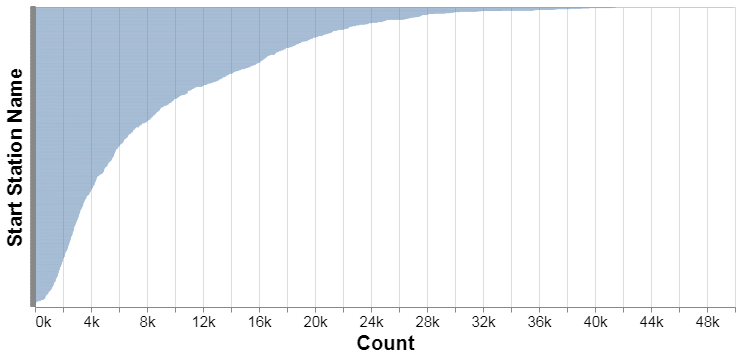

In [75]:
col_of_int = "start_station_name"
col_title = "Start Station Name"
df_start_stations = alt_hist(df_cb, col_of_int)

p = alt.Chart(df_start_stations).mark_bar().encode(
    x=alt.X("col_count", title="Count", axis=alt.Axis(format="s")),
    y=alt.Y(
        col_of_int,
        title = col_title,
        sort=alt.EncodingSortField(
            field="col_count", 
            order="descending",  
        ),
        axis= alt.Axis(labels=False)
    ),
    tooltip=[
        alt.Tooltip("col_count", title="Count", format="~s"),
        alt.Tooltip(col_of_int, title=col_title),
    ],    
)

standard_props(p)

### End Stations

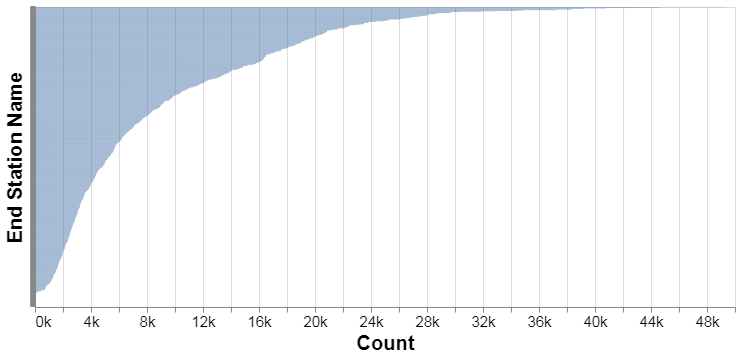

In [76]:
col_of_int = "end_station_name"
col_title = "End Station Name"
df_end_stations = alt_hist(df_cb, col_of_int)

p = alt.Chart(df_end_stations).mark_bar().encode(
    x=alt.X("col_count", title="Count", axis=alt.Axis(format="s")),
    y=alt.Y(
        col_of_int,
        title = col_title,
        sort=alt.EncodingSortField(
            field="col_count", 
            order="descending",  
        ),
        axis= alt.Axis(labels=False)
    ),
    tooltip=[
        alt.Tooltip("col_count", title="Count", format="~s"),
        alt.Tooltip(col_of_int, title=col_title),
    ],    
)

standard_props(p)

## User Type, Birth Year, and Gender

### Sanity Checks

#### Check for null values

In [145]:
df_cb[["usertype", "birth_year", "gender"]].isna().sum()

usertype      0
birth_year    0
gender        0
dtype: int64

### User Type

In [77]:
df_cb.usertype.value_counts(dropna=False)

Subscriber    5713907
Customer      1256281
Name: usertype, dtype: int64

### Gender

In [78]:
df_cb.gender.value_counts(dropna=False)

1    4583435
2    1759218
0     627535
Name: gender, dtype: int64

I am assuming that 1 is male, 2 is female, and 0 is unknown/other

### Birth Year

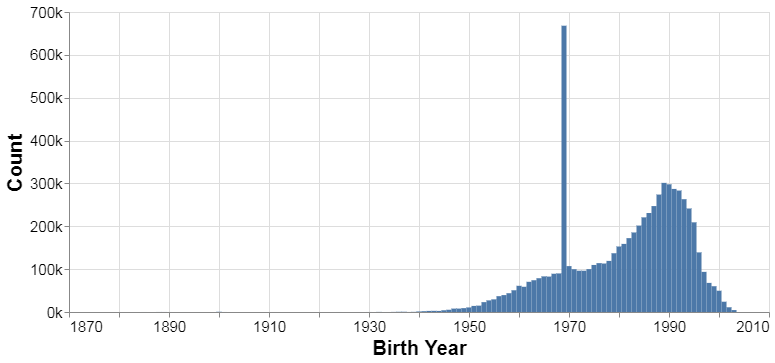

In [79]:
col_of_int = "birth_year"
col_title = "Birth Year"
df_birth_year = alt_hist(df_cb, col_of_int)

p = (
    alt.Chart(df_birth_year)
    .mark_bar()
    .encode(
        x=alt.X(col_of_int, title=col_title, axis=alt.Axis(format="c")),
        y=alt.Y("col_count", title="Count", axis=alt.Axis(format="s")),
        tooltip=[
            alt.Tooltip("col_count", title="Count", format="~s"),
            alt.Tooltip(col_of_int, title=col_title),
        ],
    )
)
standard_props(p).interactive()

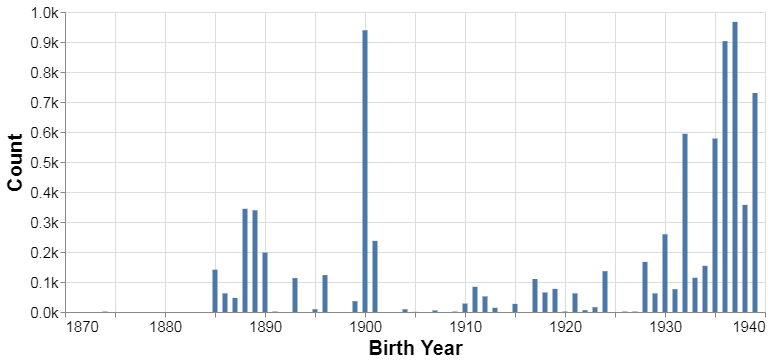

In [81]:
p = (
    alt.Chart(df_birth_year.loc[df_birth_year.birth_year < 1940])
    .mark_bar()
    .encode(
        x=alt.X(col_of_int, title=col_title, axis=alt.Axis(format="c")),
        y=alt.Y("col_count", title="Count", axis=alt.Axis(format="s")),
        tooltip=[
            alt.Tooltip("col_count", title="Count", format="~s"),
            alt.Tooltip(col_of_int, title=col_title),
        ],
    )
)
standard_props(p).interactive()

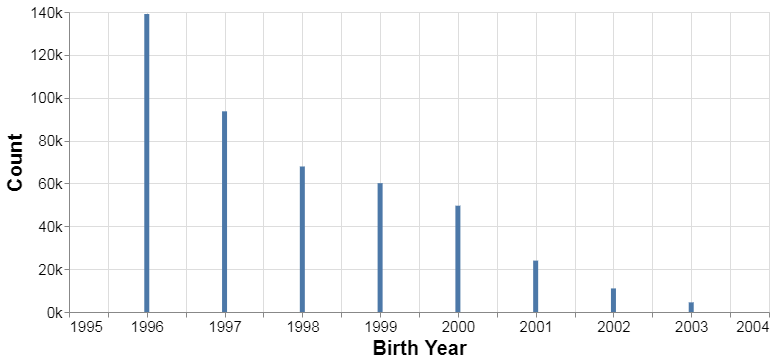

In [82]:
p = (
    alt.Chart(df_birth_year.loc[df_birth_year.birth_year > 1995])
    .mark_bar()
    .encode(
        x=alt.X(col_of_int, title=col_title, axis=alt.Axis(format="c")),
        y=alt.Y("col_count", title="Count", axis=alt.Axis(format="s")),
        tooltip=[
            alt.Tooltip("col_count", title="Count", format="~s"),
            alt.Tooltip(col_of_int, title=col_title),
        ],
    )
)
standard_props(p).interactive()

I would assume that 1969 is the default `birth year` value, hence its spike.  To prevent them from skewing any analysis, I will replace them with null values.  There are definitely some false values in that dataset, as I doubt there are any bikers over 120 years old, but there is no obvious cutoff.  However, since they are on the edge of the data they should influence any trends. 

In [83]:
df_cb.loc[df_cb.birth_year==1969, "birth_year"] = np.NAN

# Relationships to Trip Duration

## Correlation

In [187]:
df_cb_corr = df_cb.corr()

<a id='corr_plot'></a>

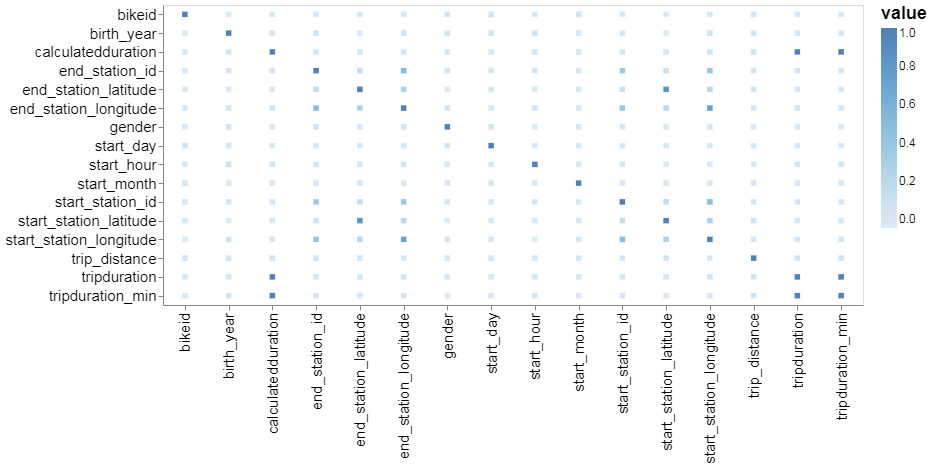

In [206]:
df_cb_corr_melt = (
    df_cb_corr.reset_index().rename(columns={"index": "var"}).melt(id_vars=["var"])
)
p = (
    alt.Chart(df_cb_corr_melt)
    .mark_square()
    .encode(
        x=alt.X("var", title=None),
        y=alt.Y("variable", title=None),
        color=alt.Color("value"),
        tooltip=[
            alt.Tooltip("var", title="Variable 1"),
            alt.Tooltip("variable", title="Variable 2"),
            alt.Tooltip("value", title="Correlation", format=".2%"),
        ],
    )
)
standard_props(p)

## Trip Duration vs Trip Distance

### Calculate Trip Distance

In [84]:
df_latlong = (
    df_cb[
        [
            "start_station_latitude",
            "start_station_longitude",
            "end_station_longitude",
            "end_station_latitude",
        ]
    ]
    .drop_duplicates()
    .copy()
)
df_latlong.shape

(286486, 4)

In [85]:
df_latlong["start_lat_long"] = list(
    zip(df_latlong.start_station_latitude, df_latlong.start_station_longitude)
)
df_latlong["end_lat_long"] = list(
    zip(df_latlong.end_station_latitude, df_latlong.end_station_longitude)
)

In [86]:
df_latlong["trip_distance"] = df_latlong.apply(
    lambda x: distance.distance(x.start_lat_long, x.end_lat_long).miles, axis=1
)

In [87]:
df_cb = df_cb.merge(
    df_latlong,
    on=[
        "start_station_latitude",
        "start_station_longitude",
        "end_station_longitude",
        "end_station_latitude",
    ],
    how="left"
)

### Plot Relationship

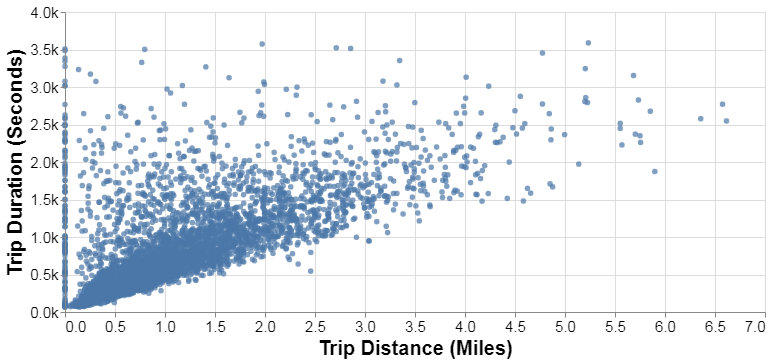

In [88]:
df_dist_time = df_cb.loc[df_cb.tripduration < (60 * 60)][
    ["trip_distance", "tripduration"]
].sample(5 * 10 ** 3, random_state=44)

p = (
    alt.Chart(df_dist_time)
    .mark_circle()
    .encode(
        x=alt.X("trip_distance", title="Trip Distance (Miles)"),
        y=alt.Y(
            "tripduration", title="Trip Duration (Seconds)", axis=alt.Axis(format="s")
        ),
        tooltip=[
            alt.Tooltip("tripduration", title="Duration (Seconds)", format="s"),
            alt.Tooltip("trip_distance", title="Distance (Miles)"),
        ],
    )
)
standard_props(p)

## Trip Duration vs Birth Year

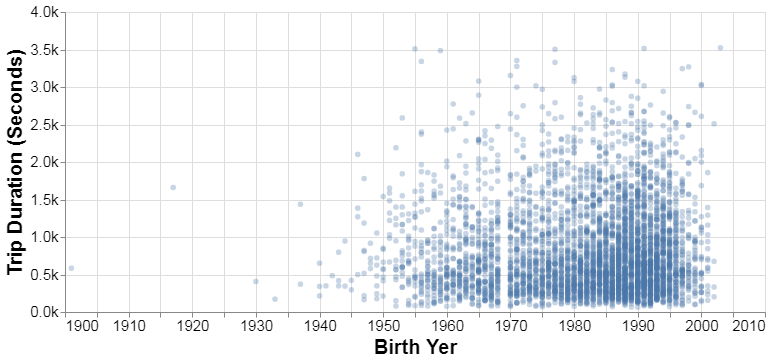

In [92]:
df_time_birth = df_cb.loc[df_cb.tripduration < (60 * 60)][
    ["birth_year", "tripduration"]
].sample(5 * 10 ** 3, random_state=44)

p = (
    alt.Chart(df_time_birth)
    .mark_circle(opacity=0.3)
    .encode(
        x=alt.X("birth_year", title="Birth Year", scale=alt.Scale(zero=False), axis=alt.Axis(format="d")),
        y=alt.Y(
            "tripduration", title="Trip Duration (Seconds)", axis=alt.Axis(format="s")
        ),
        tooltip=[
            alt.Tooltip("tripduration", title="Duration (Seconds)", format="s"),
            alt.Tooltip("birth_year", title="Birth Year"),
        ],
    )
)
standard_props(p)

## Trip Duration vs Time of Day

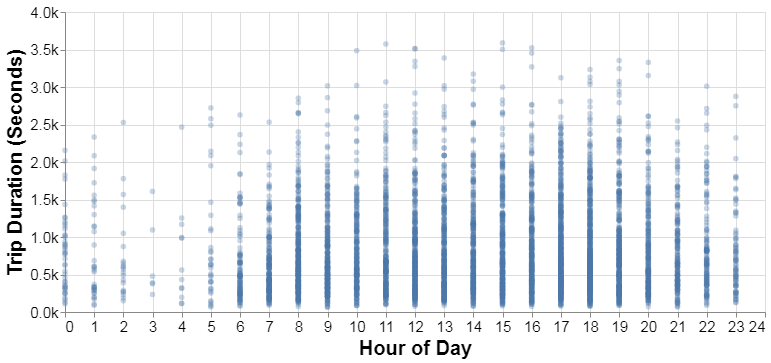

In [186]:
col_of_int = "start_hour"
col_title = "Hour of Day"
df_dur_start = df_cb.loc[df_cb.tripduration < (60 * 60)][
    ["start_hour", "tripduration"]
].sample(5 * 10 ** 3, random_state=44)

p = (
    alt.Chart(df_dur_start)
    .mark_circle(opacity=0.3)
    .encode(
        x=alt.X(col_of_int, title=col_title, scale=alt.Scale(zero=False), axis=alt.Axis(format="d")),
        y=alt.Y(
            "tripduration", title="Trip Duration (Seconds)", axis=alt.Axis(format="s")
        ),
        tooltip=[
            alt.Tooltip("tripduration", title="Duration (Seconds)", format="s"),
            alt.Tooltip(col_of_int, title=col_title),
        ],
    )
)
standard_props(p)

## Other plot ideas

- Map station id vs use

# Most used stations

In [94]:
df_cb.start_station_id.value_counts().head()

519.0     49881
497.0     41456
426.0     41150
514.0     39577
3255.0    39034
Name: start_station_id, dtype: int64

In [110]:
df_cb.tail()

6970183    23:59:00
6970184    23:59:00
6970185    23:59:00
6970186    00:00:00
6970187    00:00:00
Name: starttime, dtype: object

In [123]:
df_min.dtypes

starttime    object
ct            int64
dtype: object

0    1900-01-01 00:00:00
1    1900-01-01 00:15:00
2    1900-01-01 00:30:00
3    1900-01-01 00:45:00
4    1900-01-01 01:00:00
             ...        
91   1900-01-01 22:45:00
92   1900-01-01 23:00:00
93   1900-01-01 23:15:00
94   1900-01-01 23:30:00
95   1900-01-01 23:45:00
Name: starttime, Length: 96, dtype: datetime64[ns]

In [151]:
df_min.starttime.apply(lambda x: x.strftime('%H:%M'))

0      00:00
1      00:05
2      00:10
3      00:15
4      00:20
       ...  
280    23:35
281    23:40
282    23:45
283    23:50
284    23:55
Name: starttime, Length: 285, dtype: object

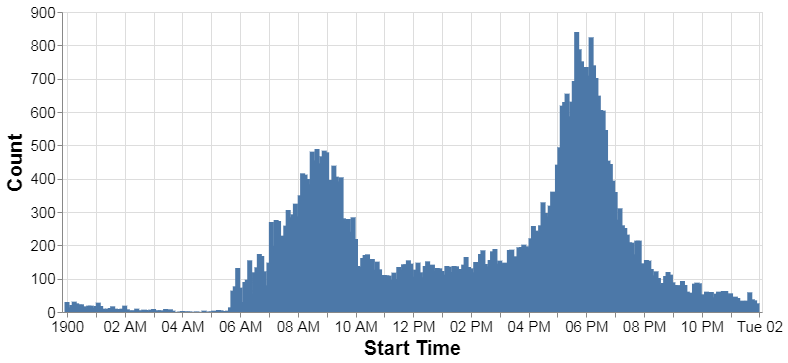

In [152]:
df_min = df_cb.loc[df_cb.start_station_id==519].starttime.dt.round("5min").dt.time.to_frame()
# df_min.starttime = pd.to_datetime(df_min.starttime, format="%H:%M:%S")
df_min["ct"] = 1
df_min = df_min.groupby("starttime", as_index=False).count()
df_min["starttime_date"] = pd.to_datetime(df_min.starttime, format="%H:%M:%S")
df_min.starttime = df_min.starttime.apply(lambda x: x.strftime('%H:%M'))

p = (
    alt.Chart(df_min)
    .mark_bar()
    .encode(
        x=alt.X("starttime_date:T", title="Start Time"),
        y=alt.Y(
            "ct", title="Count", axis=alt.Axis(format="s")
        ),
        tooltip=[
            alt.Tooltip("ct", title="Count", format="s"),
            alt.Tooltip("starttime", title="Start Time"),
        ],
    )
)
standard_props(p).interactive()

In [146]:
df_min

starttime  ct      starttime_date
0    00:00:00  30 1900-01-01 00:00:00
1    00:05:00  14 1900-01-01 00:05:00
2    00:10:00  21 1900-01-01 00:10:00
3    00:15:00  31 1900-01-01 00:15:00
4    00:20:00  26 1900-01-01 00:20:00
..        ...  ..                 ...
280  23:35:00  34 1900-01-01 23:35:00
281  23:40:00  59 1900-01-01 23:40:00
282  23:45:00  38 1900-01-01 23:45:00
283  23:50:00  35 1900-01-01 23:50:00
284  23:55:00  26 1900-01-01 23:55:00

[285 rows x 3 columns]

# Building a GLM

In [210]:
import h2o
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
h2o.init(min_mem_size="7G")

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "1.8.0_222"; OpenJDK Runtime Environment (build 1.8.0_222-8u222-b10-1ubuntu1~16.04.1-b10); OpenJDK 64-Bit Server VM (build 25.222-b10, mixed mode)
  Starting server from /home/ubuntu/.local/share/virtualenvs/msnow_wip-lPAcKwpP/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp7ik5l4pp
  JVM stdout: /tmp/tmp7ik5l4pp/h2o_ubuntu_started_from_python.out
  JVM stderr: /tmp/tmp7ik5l4pp/h2o_ubuntu_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


--------------------------  ------------------------------------------------------------------
H2O cluster uptime:         02 secs
H2O cluster timezone:       America/New_York
H2O data parsing timezone:  UTC
H2O cluster version:        3.26.0.5
H2O cluster version age:    1 month and 14 days
H2O cluster name:           H2O_from_python_ubuntu_qkdl0e
H2O cluster total nodes:    1
H2O cluster free memory:    6.983 Gb
H2O cluster total cores:    8
H2O cluster allowed cores:  8
H2O cluster status:         accepting new members, healthy
H2O connection url:         http://127.0.0.1:54321
H2O connection proxy:
H2O internal security:      False
H2O API Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, TargetEncoder, Core V4
Python version:             3.7.4 final
--------------------------  ------------------------------------------------------------------

In [216]:
df_cb.columns

Index(['tripduration', 'starttime', 'stoptime', 'start_station_id',
       'start_station_name', 'start_station_latitude',
       'start_station_longitude', 'end_station_id', 'end_station_name',
       'end_station_latitude', 'end_station_longitude', 'bikeid', 'usertype',
       'birth_year', 'gender', 'calculatedduration', 'duration_diff',
       'tripduration_min', 'start_month', 'start_day', 'start_date',
       'start_dow', 'start_hour', 'start_lat_long', 'end_lat_long',
       'trip_distance'],
      dtype='object')

In [258]:
outcome_y = "tripduration_min"
train_sz = 5 * 10 ** 5
test_sz =3 * 10 ** 5
df_cb_model = df_cb[
    [
        "tripduration_min",
        "starttime",
        "start_station_id",
        "start_station_name",
        "start_station_latitude",
        "start_station_longitude",
        "bikeid",
        "usertype",
        "birth_year",
        "gender",
        "start_month",
        "start_day",
        "start_date",
        "start_dow",
        "start_hour",
    ]
].copy()
df_cb_model = df_cb_model.loc[df_cb_model.tripduration_min<60*4]
df_train, df_test = train_test_split(df_cb_model, train_smp=train_sz, test_smp=test_sz)
df_train.shape, df_test.shape

((500000, 15), (300000, 15))

In [259]:
train_h2o = h2o.H2OFrame(df_train)
train_h2o[outcome_y] = train_h2o[outcome_y]
test_h2o = h2o.H2OFrame(df_test)
test_h2o[outcome_y] = test_h2o[outcome_y]

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [228]:
linear_param = {
    "max_runtime_secs" : 25
    ,"nfolds":3
    ,"lambda_":0
    ,"remove_collinear_columns":True
    ,"alpha":0
#     ,"family":'binomial'
    ,"standardize": True
}

In [260]:
x_cols = [x for x in df_cb_model.columns if x not in  [outcome_y]]
h2o_glm = H2OGeneralizedLinearEstimator()
h2o_glm.train(x=x_cols, y=outcome_y, training_frame=train_h2o)

glm Model Build progress: |███████████████████████████████████████████████| 100%


In [261]:
h2o_glm.model_performance(train_h2o)


ModelMetricsRegressionGLM: glm
** Reported on test data. **

MSE: 158.74195195516288
RMSE: 12.599283787388982
MAE: 8.076047099594737
RMSLE: 0.7208705305213903
R^2: 0.11791842179799916
Mean Residual Deviance: 158.74195195516288
Null degrees of freedom: 499999
Residual degrees of freedom: 499707
Null deviance: 89981446.09184757
Residual deviance: 79370975.97758144
AIC: 3953166.503275806


In [262]:
h2o_glm.model_performance(test_h2o)


ModelMetricsRegressionGLM: glm
** Reported on test data. **

MSE: 160.1807017088014
RMSE: 12.656251487261203
MAE: 8.085422260509482
RMSLE: 0.7213360372238161
R^2: 0.11702819348970417
Mean Residual Deviance: 160.1807017088014
Null degrees of freedom: 299999
Residual degrees of freedom: 299707
Null deviance: 54423424.43751838
Residual deviance: 48054210.51264042
AIC: 2374841.889014085


In [263]:
df_test["predicted_duration"] = h2o_glm.predict(test_h2o).as_data_frame()

glm prediction progress: |████████████████████████████████████████████████| 100%


In [252]:
df_test.columns

Index(['tripduration_min', 'starttime', 'start_station_id',
       'start_station_name', 'start_station_latitude',
       'start_station_longitude', 'bikeid', 'usertype', 'birth_year', 'gender',
       'start_month', 'start_day', 'start_date', 'start_dow', 'start_hour',
       'predicted_duration'],
      dtype='object')

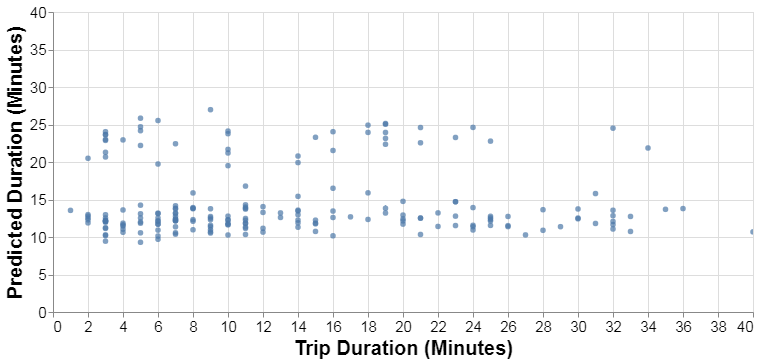

In [270]:
df_tmp = df_test.sample(5 * 10 ** 3, random_state=44)

p = (
    alt.Chart(df_tmp)
    .mark_circle(clip=True)
    .encode(
        x=alt.X(
            "tripduration_min",
            title="Trip Duration (Minutes)",
            scale=alt.Scale(zero=False, domain=(0,40)),
            axis=alt.Axis(format="d"),
        ),
        y=alt.Y(
            "predicted_duration",
            title="Predicted Duration (Minutes)",
            axis=alt.Axis(format="d"),
            scale=alt.Scale(domain=(0,40))
        ),
        tooltip=[
            alt.Tooltip("tripduration_min", title="Duration", format="s"),
            alt.Tooltip("predicted_duration", title="Predicted Duration"),
        ],
    )
)
standard_props(p)

In [272]:
df_test.reset_index(drop=True).to_feather("../downloads/model_predictions.feather")